# Notebook to define ensemble for production, cm level
Version developed for ViEWS monthly updates: Fatalities002
## Including ensemble weighting

This notebook defines the ensemble used for production: selects a set of pre-trained models, retrieves and calibrates them, computes weights, and computes and stores the ensemble model predictions.

Models are stored in model storage and most of them specified in the notebook fat_cm_constituentmodels

The notebook draws on the following files in this repository:

Script file: 
    Ensembling.py
    FetchData.py

Lists of models:
    ModelList_cm_{dev_id}.csv (not yet functional)
    List of pickles at local directory (will rewrite to drop dependence on this)

In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
# Views 3
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
from views_runs import storage, ModelMetadata
from views_runs.storage import store, retrieve, fetch_metadata
from views_forecasts.extensions import *
# Other packages
import pickle as pkl

In [2]:
# Packages from this repository, Tools folder
import sys
sys.path.append('../')
sys.path.append('../Tools')
sys.path.append('../Intermediates')
import os

from Ensembling import CalibratePredictions, RetrieveStoredPredictions, mean_sd_calibrated, gam_calibrated, get_genetic_weights, make_run_from_step
from FetchData import FetchData, RetrieveFromList
from ViewsEstimators import *

# Parallel processing and genetic algorithm
from joblib import Parallel, delayed, cpu_count
from functools import partial
from genetic2 import *
from pathlib import Path

Refreshing


In [3]:
# Common parameters:

dev_id = 'Fatalities002'
run_id = 'Fatalities002'
EndOfHistory = 517
RunGeneticAlgo = False
level = 'cm'
get_future = False

username = os.getlogin()

steps = [*range(1, 36+1, 1)] # Which steps to train and predict for

fi_steps = [1,3,6,12,36]
# Specifying partitions

calib_partitioner_dict = {"train":(121,408),"predict":(409,456)}
test_partitioner_dict = {"train":(121,456),"predict":(457,504)}
future_partitioner_dict = {"train":(121,504),"predict":(505,516)}
calib_partitioner =  views_runs.DataPartitioner({"calib":calib_partitioner_dict})
test_partitioner =  views_runs.DataPartitioner({"test":test_partitioner_dict})
future_partitioner =  views_runs.DataPartitioner({"future":future_partitioner_dict})

Mydropbox = f'/Users/{username}/Dropbox (ViEWS)/ViEWS/'
localpath = f'/Users/{username}/Pickles/'
overleafpath = f'/Users/{username}/Dropbox (ViEWS)/Apps/Overleaf/ViEWS predicting fatalities/Tables/'


print('Dropbox path set to',Mydropbox)
print('Overleaf path set to',overleafpath)
print('Local path set to',localpath)

Dropbox path set to /Users/jim/Dropbox (ViEWS)/ViEWS/
Overleaf path set to /Users/jim/Dropbox (ViEWS)/Apps/Overleaf/ViEWS predicting fatalities/Tables/
Local path set to /Users/jim/Pickles/


In [4]:
from ModelDefinitions import DefineEnsembleModels

ModelList = DefineEnsembleModels(level)
    
i = 0
for model in ModelList:
    print(i, model['modelname'], model['data_train'])
    i = i + 1

0 fatalities002_baseline_rf baseline002
1 fatalities002_conflicthistory_rf conflict_ln
2 fatalities002_conflicthistory_gbm conflict_ln
3 fatalities002_conflicthistory_hurdle_lgb conflict_ln
4 fatalities002_conflicthistory_long_xgb conflictlong_ln
5 fatalities002_vdem_hurdle_xgb vdem_short
6 fatalities002_wdi_rf wdi_short
7 fatalities002_topics_rf topics_002
8 fatalities002_topics_xgb topics_002
9 fatalities002_topics_hurdle_lgb topics_002
10 fatalities002_joint_broad_rf joint_broad
11 fatalities002_joint_broad_hurdle_rf joint_broad
12 fatalities002_joint_narrow_xgb joint_narrow
13 fatalities002_joint_narrow_hurdle_xgb joint_narrow
14 fatalities002_joint_narrow_hurdle_lgb joint_narrow
15 fatalities002_all_pca3_xgb all_features
16 fatalities002_aquastat_rf aquastat
17 fatalities002_faostat_rf faostat
18 fatalities002_faoprices_rf faoprices
19 fatalities002_imfweo_rf imfweo
20 fatalities002_Markov_glm joint_narrow
21 fatalities002_Markov_rf joint_narrow


# Retrieve and calibrate predictions

In [5]:
# Retrieving the predictions for calibration and test partitions
# The ModelList contains the predictions organized by model

ModelList = RetrieveStoredPredictions(ModelList, steps, EndOfHistory, dev_id, level, get_future)

ModelList = CalibratePredictions(ModelList, EndOfHistory, steps)

0 fatalities002_baseline_rf
pr_46_cm_fatalities002_baseline_rf_calib.parquet
pr_46_cm_fatalities002_baseline_rf_test.parquet
1 fatalities002_conflicthistory_rf
pr_46_cm_fatalities002_conflicthistory_rf_calib.parquet
pr_46_cm_fatalities002_conflicthistory_rf_test.parquet
2 fatalities002_conflicthistory_gbm
pr_46_cm_fatalities002_conflicthistory_gbm_calib.parquet
pr_46_cm_fatalities002_conflicthistory_gbm_test.parquet
3 fatalities002_conflicthistory_hurdle_lgb
pr_46_cm_fatalities002_conflicthistory_hurdle_lgb_calib.parquet
pr_46_cm_fatalities002_conflicthistory_hurdle_lgb_test.parquet
4 fatalities002_conflicthistory_long_xgb
pr_46_cm_fatalities002_conflicthistory_long_xgb_calib.parquet
pr_46_cm_fatalities002_conflicthistory_long_xgb_test.parquet
5 fatalities002_vdem_hurdle_xgb
pr_46_cm_fatalities002_vdem_hurdle_xgb_calib.parquet
pr_46_cm_fatalities002_vdem_hurdle_xgb_test.parquet
6 fatalities002_wdi_rf
pr_46_cm_fatalities002_wdi_rf_calib.parquet
pr_46_cm_fatalities002_wdi_rf_test.parquet

In [6]:
ModelList[0].keys()

dict_keys(['modelname', 'algorithm', 'depvar', 'data_train', 'queryset', 'preprocessing', 'level', 'description', 'long_description', 'predstore_calib', 'predstore_test', 'predictions_calib_df', 'predictions_test_df', 'calib_df_cal_expand', 'test_df_cal_expand', 'calib_df_calibrated', 'test_df_calibrated', 'calibration_gams', 'expanded', 'shiftsize'])

In [7]:
ModelList[0]['predictions_calib_df']

ln_ged_sb_dep  step_pred_1  step_pred_2  step_pred_3  \
month_id country_id                                                         
409      1                0.000000     0.006401     0.011513     0.016645   
         2                0.000000     0.005335     0.005976     0.008503   
         3                0.000000     0.005335     0.006013     0.006250   
         4                0.000000     0.006815     0.012445     0.017810   
         5                0.000000     0.005335     0.005976     0.008503   
...                            ...          ...          ...          ...   
456      242              0.000000     0.013490     0.012018     0.007386   
         243              0.000000     0.006120     0.009396     0.006621   
         244              0.000000     0.018680     0.019899     0.019778   
         245              1.609438     2.552713     2.022251     1.847560   
         246              4.143135     4.238428     3.122434     2.999334   

                     step_pred_4  step_pred_5  step_pred_6  step_pred_7  \
month_id country_id                                                       
409      1              0.020572     0.022618     0.020907     0.035134   
         2              0.006467     0.008448     0.009998     0.074236   
         3              0.005953     0.006131     0.006532     0.028521   
         4              0.021847     0.023347     0.023289     0.030904   
         5              0.006467     0.008448     0.009998     0.074236   
...                          ...          ...          ...          ...   
456      242            0.007315     0.007894     0.008370     0.008685   
         243            0.006564     0.006972     0.007530     0.008085   
         244            0.021429     0.023350     0.023270     0.020045   
         245            1.195309     1.518802     2.209540     3.731940   
         246            2.846674     3.687084     2.953134     2.412115   

                     step_pred_8  step_pred_9  ...  step_pred_27  \
month_id country_id                            ...                 
409      1              0.073273     0.063854  ...      0.056821   
         2              0.113239     0.096540  ...      0.011768   
         3              0.026688     0.022710  ...      0.005436   
         4              0.025742     0.030406  ...      0.063188   
         5              0.113239     0.096540  ...      0.011768   
...                          ...          ...  ...           ...   
456      242            0.011867     0.015055  ...      0.016783   
         243            0.011644     0.014938  ...      0.010975   
         244            0.026850     0.026552  ...      0.022625   
         245            2.192725     1.779886  ...      2.575527   
         246            4.373387     2.784211  ...      2.131809   

                     step_pred_28  step_pred_29  step_pred_30  step_pred_31  \
month_id country_id                                                           
409      1               0.058777      0.066537      0.065192      0.079506   
         2               0.006572      0.006829      0.023463      0.011362   
         3               0.004190      0.004644      0.008695      0.005404   
         4               0.066900      0.073111      0.086794      0.089257   
         5               0.006572      0.006829      0.023463      0.011362   
...                           ...           ...           ...           ...   
456      242             0.020618      0.018425      0.015857      0.018976   
         243             0.015185      0.014816      0.014136      0.019546   
         244             0.021514      0.048579      0.088737      0.091048   
         245             2.501434      2.860257      3.570433      3.534798   
         246             1.499405      2.525434      1.963518      2.874455   

                     step_pred_32  step_pred_33  step_pred_34  step_pred_35  \
month_id country_id                                

# Genetic algorithm

In [8]:
super_walrus_genes = np.array([0, 0.010, 0.015, 0.020, 0.025, 0.030, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.25, 0.30])
steps_to_optimize = [1,2,3,4,6,9,12,15,18,24,30,36]
generations = 100

RunGeneticAlgo = True

cpus = cpu_count()-2 if cpu_count()>2 else 1
cpus - len(steps_to_optimize)

2

In [9]:
i_weights_df = get_genetic_weights(run_algorithm=RunGeneticAlgo,mlist=ModelList, steps=steps, steps_to_optimize=steps_to_optimize, generations=generations, cpus=cpus, gene_set=super_walrus_genes)
i_weights_df.head(25)

Estimating genetic weights, current time: 2023-03-27 14:17:29.849088
Refreshing
GEN 0 :AVG FITNESS BEST 10: 8.666541806529068, BEST FIT : 14.748380930752099
GEN 1 :Refreshing
AVG FITNESS BEST 10: 16.02964305309245, BEST FIT : 17.953688032456483
GEN 2 :AVG FITNESS BEST 10: 17.19035447072178, BEST FIT : 18.567111558930225
GEN 3 :GEN 0 :AVG FITNESS BEST 10: 17.545120476230665, BEST FIT : 18.567111558930225
GEN 4 :AVG FITNESS BEST 10: 7.344673917013867, BEST FIT : 11.55644289685789
GEN 1 :AVG FITNESS BEST 10: 17.686605911205, BEST FIT : 18.567111558930225
GEN 5 :AVG FITNESS BEST 10: 11.151185269285724, BEST FIT : 11.55644289685789
GEN 2 :AVG FITNESS BEST 10: 17.872381811122402, BEST FIT : 18.567111558930225
GEN 6 :AVG FITNESS BEST 10: 11.490158766868586, BEST FIT : 11.758672851863057
GEN 3 :AVG FITNESS BEST 10: 11.573519545956017, BEST FIT : 11.758672851863057
GEN 4 :AVG FITNESS BEST 10: 18.03107750492463, BEST FIT : 18.567111558930225
GEN 7 :AVG FITNESS BEST 10: 11.673251863140596, BEST F

GEN 9 :AVG FITNESS BEST 10: 12.924184103840076, BEST FIT : 13.159100387246442
GEN 23 :AVG FITNESS BEST 10: 19.816600087825424, BEST FIT : 20.139950202995916
GEN 25 :AVG FITNESS BEST 10: 5.409662010365674, BEST FIT : 5.688910528079759
GEN 3 :AVG FITNESS BEST 10: 7.768546872734308, BEST FIT : 7.876522686675511
GEN 13 :AVG FITNESS BEST 10: 10.383103593977719, BEST FIT : 10.568093827974337
GEN 21 :AVG FITNESS BEST 10: 6.459575213260858, BEST FIT : 6.491436010732754
GEN 10 :AVG FITNESS BEST 10: 5.597085487515849, BEST FIT : 5.822773588046243
GEN 4 :AVG FITNESS BEST 10: 9.591517782683283, BEST FIT : 9.748071985019672
GEN 16 :AVG FITNESS BEST 10: 5.6637739185597145, BEST FIT : 5.822773588046243
GEN 5 :Refreshing
AVG FITNESS BEST 10: 7.810666953979722, BEST FIT : 7.876522686675511
GEN 14 :AVG FITNESS BEST 10: 13.110279909310027, BEST FIT : 13.260579756480748
GEN 24 :AVG FITNESS BEST 10: 6.4851305783415825, BEST FIT : 6.596661639616236
GEN 11 :AVG FITNESS BEST 10: 19.90339060703073, BEST FIT : 

GEN 18 :AVG FITNESS BEST 10: 6.813010879074926, BEST FIT : 6.936340129496133
GEN 21 :AVG FITNESS BEST 10: 5.1926856341793215, BEST FIT : 5.2301270622048035
GEN 15 :GEN 0 :AVG FITNESS BEST 10: 4.668286345779892, BEST FIT : 4.710981117433053
GEN 12 :AVG FITNESS BEST 10: 4.162488158461371, BEST FIT : 4.249156085161372
GEN 8 :AVG FITNESS BEST 10: 3.1509792172922695, BEST FIT : 3.319801915507709
GEN 1 :AVG FITNESS BEST 10: 8.007697314645664, BEST FIT : 8.032415001155002
GEN 24 :AVG FITNESS BEST 10: 13.48669790335571, BEST FIT : 13.585361704165546
GEN 32 :AVG FITNESS BEST 10: 9.96543250027907, BEST FIT : 10.065413496923624
GEN 26 :AVG FITNESS BEST 10: 6.100576088708307, BEST FIT : 6.116537671528894
GEN 19 :AVG FITNESS BEST 10: 3.2797180554890346, BEST FIT : 3.3432222760336825
GEN 2 :AVG FITNESS BEST 10: 20.324249483832745, BEST FIT : 20.423469634553673
GEN 34 :AVG FITNESS BEST 10: 4.676867123259375, BEST FIT : 4.710981117433053
GEN 13 :AVG FITNESS BEST 10: 5.2034864086393515, BEST FIT : 5.23

GEN 12 :AVG FITNESS BEST 10: 8.079359788404105, BEST FIT : 8.236969892364684
GEN 31 :AVG FITNESS BEST 10: 13.653925425844381, BEST FIT : 13.817341170772222
GEN 38 :AVG FITNESS BEST 10: 4.814350038766404, BEST FIT : 4.838881218823249
GEN 22 :AVG FITNESS BEST 10: 6.151784726549813, BEST FIT : 6.161840836895187
GEN 27 :AVG FITNESS BEST 10: 10.970086268558125, BEST FIT : 11.005168244903984
GEN 36 :AVG FITNESS BEST 10: 6.917210697976159, BEST FIT : 6.96294505541832
GEN 29 :AVG FITNESS BEST 10: 3.516170351426024, BEST FIT : 3.5302109810139153
GEN 16 :AVG FITNESS BEST 10: 5.3004224903165875, BEST FIT : 5.373319666805915
GEN 24 :AVG FITNESS BEST 10: 10.091108769259138, BEST FIT : 10.15169549536783
GEN 33 :AVG FITNESS BEST 10: 20.45168256262226, BEST FIT : 20.532926581155944
GEN 40 :AVG FITNESS BEST 10: 3.2409700004942152, BEST FIT : 3.251757232660376
GEN 13 :AVG FITNESS BEST 10: 4.287577954040364, BEST FIT : 4.304579924493839
GEN 20 :AVG FITNESS BEST 10: 3.5235764913384315, BEST FIT : 3.530210

GEN 46 :AVG FITNESS BEST 10: 3.5626144874614334, BEST FIT : 3.565182034484137
GEN 27 :AVG FITNESS BEST 10: 5.384576426750703, BEST FIT : 5.386623553932909
GEN 32 :AVG FITNESS BEST 10: 4.365837799830482, BEST FIT : 4.387206549734149
GEN 30 :AVG FITNESS BEST 10: 4.904368727021596, BEST FIT : 4.9362959862795215
GEN 31 :AVG FITNESS BEST 10: 13.82507588078334, BEST FIT : 13.926725510528247
GEN 45 :AVG FITNESS BEST 10: 7.028684709198039, BEST FIT : 7.047979648455471
GEN 37 :AVG FITNESS BEST 10: 8.230162735461473, BEST FIT : 8.2438615406317
GEN 39 :AVG FITNESS BEST 10: 6.197294947519819, BEST FIT : 6.2313172447677925
GEN 37 :AVG FITNESS BEST 10: 10.158634866515309, BEST FIT : 10.173114260843665
GEN 41 :AVG FITNESS BEST 10: 3.2910715354389533, BEST FIT : 3.301547525617306
GEN 25 :AVG FITNESS BEST 10: 3.5635238461618313, BEST FIT : 3.565182034484137
GEN 28 :AVG FITNESS BEST 10: 4.368661873336775, BEST FIT : 4.387206549734149
GEN 31 :AVG FITNESS BEST 10: 11.070934066695452, BEST FIT : 11.0742022

GEN 49 :AVG FITNESS BEST 10: 11.095700954289729, BEST FIT : 11.09570095428973
GEN 51 :AVG FITNESS BEST 10: 13.930483755050938, BEST FIT : 13.964307955755178
GEN 52 :AVG FITNESS BEST 10: 3.575754514534919, BEST FIT : 3.583650128443597
GEN 39 :AVG FITNESS BEST 10: 7.068801753099457, BEST FIT : 7.129394856231194
GEN 45 :AVG FITNESS BEST 10: 5.4162861639407645, BEST FIT : 5.444037812250938
GEN 41 :AVG FITNESS BEST 10: 4.992897602062489, BEST FIT : 5.018262940130027
GEN 40 :AVG FITNESS BEST 10: 3.3109857559146008, BEST FIT : 3.3139987333966805
GEN 35 :AVG FITNESS BEST 10: 4.3902878512858505, BEST FIT : 4.397675638365142
GEN 41 :AVG FITNESS BEST 10: 20.660806682166214, BEST FIT : 20.678746391350863
GEN 54 :AVG FITNESS BEST 10: 3.576396068102311, BEST FIT : 3.583650128443597
GEN 40 :AVG FITNESS BEST 10: 6.236793247112941, BEST FIT : 6.255075870994135
GEN 47 :AVG FITNESS BEST 10: 8.286660321691794, BEST FIT : 8.292696822279094
GEN 47 :AVG FITNESS BEST 10: 10.196231626698872, BEST FIT : 10.2142

GEN 58 :AVG FITNESS BEST 10: 6.3123439524749765, BEST FIT : 6.329897439809322
GEN 55 :AVG FITNESS BEST 10: 11.161159851823452, BEST FIT : 11.162724028352718
GEN 60 :AVG FITNESS BEST 10: 7.1412569549501885, BEST FIT : 7.194180675476549
GEN 53 :AVG FITNESS BEST 10: 4.414670741635452, BEST FIT : 4.416548042972014
GEN 51 :AVG FITNESS BEST 10: 14.00647887862714, BEST FIT : 14.07378382541641
GEN 60 :AVG FITNESS BEST 10: 3.3227393137422574, BEST FIT : 3.3245225313878763
GEN 44 :AVG FITNESS BEST 10: 5.47388770859044, BEST FIT : 5.498497856833044
GEN 50 :AVG FITNESS BEST 10: 3.599072528274405, BEST FIT : 3.6002432428017968
GEN 51 :AVG FITNESS BEST 10: 8.313658070275084, BEST FIT : 8.323108206965498
GEN 55 :AVG FITNESS BEST 10: 10.25286400266172, BEST FIT : 10.278676164932744
GEN 59 :AVG FITNESS BEST 10: 5.055534709786197, BEST FIT : 5.065435944166185
GEN 49 :AVG FITNESS BEST 10: 20.7936050258087, BEST FIT : 20.81368875083722
GEN 62 :AVG FITNESS BEST 10: 11.162724028352716, BEST FIT : 11.1627240

GEN 58 :AVG FITNESS BEST 10: 3.6066492583909957, BEST FIT : 3.6093576053378382
GEN 61 :AVG FITNESS BEST 10: 8.418885485541074, BEST FIT : 8.465161868357608
GEN 63 :AVG FITNESS BEST 10: 7.229362317062465, BEST FIT : 7.232926916034846
GEN 61 :AVG FITNESS BEST 10: 6.335937913162956, BEST FIT : 6.341270229899156
GEN 64 :AVG FITNESS BEST 10: 4.438339092870233, BEST FIT : 4.445659331759798
GEN 61 :AVG FITNESS BEST 10: 11.169336360277049, BEST FIT : 11.187674330693872
GEN 70 :AVG FITNESS BEST 10: 14.144644911521965, BEST FIT : 14.144644911521965
GEN 68 :AVG FITNESS BEST 10: 5.119740957108219, BEST FIT : 5.141109039670042
GEN 57 :AVG FITNESS BEST 10: 3.3499274035078366, BEST FIT : 3.3533680686675003
GEN 53 :AVG FITNESS BEST 10: 3.608307446604438, BEST FIT : 3.6117256309770465
GEN 62 :AVG FITNESS BEST 10: 20.85544223679719, BEST FIT : 20.938747609268777
GEN 70 :AVG FITNESS BEST 10: 10.399613938425656, BEST FIT : 10.445282578803688
GEN 68 :AVG FITNESS BEST 10: 5.504698224683155, BEST FIT : 5.511

GEN 77 :AVG FITNESS BEST 10: 6.399060127391658, BEST FIT : 6.405700897544807
GEN 73 :AVG FITNESS BEST 10: 7.235846142076676, BEST FIT : 7.238102547949062
GEN 69 :AVG FITNESS BEST 10: 14.17586790545278, BEST FIT : 14.178784672909384
GEN 76 :AVG FITNESS BEST 10: 5.1425739253863965, BEST FIT : 5.147147055879767
GEN 65 :AVG FITNESS BEST 10: 8.473836033394637, BEST FIT : 8.474926122282088
GEN 73 :AVG FITNESS BEST 10: 11.248669691475232, BEST FIT : 11.33281951911802
GEN 80 :AVG FITNESS BEST 10: 3.3603751435904172, BEST FIT : 3.3677839445920648
GEN 61 :AVG FITNESS BEST 10: 3.6225763918689453, BEST FIT : 3.6229821987863087
GEN 72 :AVG FITNESS BEST 10: 4.455707960518772, BEST FIT : 4.461295876587254
GEN 71 :AVG FITNESS BEST 10: 10.511795543305327, BEST FIT : 10.511795543305329
GEN 76 :AVG FITNESS BEST 10: 5.5176826228820435, BEST FIT : 5.5205536714163195
GEN 67 :AVG FITNESS BEST 10: 20.971406975428284, BEST FIT : 21.013748955069858
GEN 78 :AVG FITNESS BEST 10: 6.402186054562667, BEST FIT : 6.40

GEN 81 :AVG FITNESS BEST 10: 10.520195340235167, BEST FIT : 10.54005119226623
GEN 84 :AVG FITNESS BEST 10: 14.197146300117549, BEST FIT : 14.197217467861607
GEN 85 :AVG FITNESS BEST 10: 7.243344584412651, BEST FIT : 7.254641013472028
GEN 78 :AVG FITNESS BEST 10: 8.543756265811648, BEST FIT : 8.571922621986758
GEN 82 :AVG FITNESS BEST 10: 11.385409394585327, BEST FIT : 11.432513930280765
GEN 89 :AVG FITNESS BEST 10: 6.406689485304449, BEST FIT : 6.409318731291803
GEN 82 :AVG FITNESS BEST 10: 5.522600922370003, BEST FIT : 5.534922525845732
GEN 75 :AVG FITNESS BEST 10: 5.172432425807791, BEST FIT : 5.180360723735224
GEN 74 :AVG FITNESS BEST 10: 3.368000612569613, BEST FIT : 3.368963438570504
GEN 69 :AVG FITNESS BEST 10: 4.463663331795836, BEST FIT : 4.467735083514625
GEN 81 :AVG FITNESS BEST 10: 3.6262673244922112, BEST FIT : 3.627985224687398
GEN 82 :AVG FITNESS BEST 10: 21.018249795807197, BEST FIT : 21.02509510593743
GEN 86 :AVG FITNESS BEST 10: 10.52660864799687, BEST FIT : 10.5541021

GEN 90 :AVG FITNESS BEST 10: 5.1830031880891365, BEST FIT : 5.187097436654081
GEN 82 :AVG FITNESS BEST 10: 3.37415205067258, BEST FIT : 3.3766502921283905
GEN 77 :AVG FITNESS BEST 10: 7.25765730681898, BEST FIT : 7.273556501543527
GEN 87 :AVG FITNESS BEST 10: 3.643089723537326, BEST FIT : 3.6444423682416223
GEN 91 :AVG FITNESS BEST 10: 14.20174201930167, BEST FIT : 14.210844113218746
GEN 94 :AVG FITNESS BEST 10: 11.432705438464065, BEST FIT : 11.43442901211378
GEN 98 :AVG FITNESS BEST 10: 6.425665511899372, BEST FIT : 6.4387237467407825
GEN 91 :AVG FITNESS BEST 10: 8.580212540221398, BEST FIT : 8.587826546101285
GEN 91 :AVG FITNESS BEST 10: 10.612350589000078, BEST FIT : 10.620433335219467
GEN 93 :AVG FITNESS BEST 10: 5.538347923477285, BEST FIT : 5.5433285439996975
GEN 84 :AVG FITNESS BEST 10: 21.06221604424129, BEST FIT : 21.110477892559203
GEN 94 :AVG FITNESS BEST 10: 4.468079983053078, BEST FIT : 4.46958860508777
GEN 91 :AVG FITNESS BEST 10: 5.185697873256679, BEST FIT : 5.18709743

GEN 97 :AVG FITNESS BEST 10: 5.553764764708526, BEST FIT : 5.558148288868675
GEN 93 :AVG FITNESS BEST 10: 3.3777108998305456, BEST FIT : 3.379351428383296
GEN 87 :AVG FITNESS BEST 10: 5.201451817405537, BEST FIT : 5.202788650946055
GEN 93 :AVG FITNESS BEST 10: 7.273465881385333, BEST FIT : 7.273556501543527
GEN 98 :AVG FITNESS BEST 10: 5.554042310697598, BEST FIT : 5.558148288868675
GEN 94 :AVG FITNESS BEST 10: 3.3777108998305456, BEST FIT : 3.379351428383296
GEN 88 :AVG FITNESS BEST 10: 5.203144489041485, BEST FIT : 5.206347031900356
GEN 94 :AVG FITNESS BEST 10: 7.273567980396711, BEST FIT : 7.273671290075391
GEN 99 :AVG FITNESS BEST 10: 5.555237829963763, BEST FIT : 5.558148288868675
GEN 95 :AVG FITNESS BEST 10: 3.37782611129652, BEST FIT : 3.379351428383296
GEN 89 :AVG FITNESS BEST 10: 5.203144489041485, BEST FIT : 5.206347031900356
GEN 95 :AVG FITNESS BEST 10: 7.273590938103085, BEST FIT : 7.273671290075391
Optimized
AVG FITNESS BEST 10: 5.55649094679854, BEST FIT : 5.5581482888686

,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,step_pred_10,...,step_pred_27,step_pred_28,step_pred_29,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36
fatalities002_baseline_rf,0.000,0.020,0.000,0.010,0.0175,0.025,0.016667,0.008333,0.000,0.000000,...,0.0125,0.016667,0.020833,0.025,0.047500,0.070000,0.0925,0.115000,0.137500,0.160
fatalities002_conflicthistory_rf,0.140,0.100,0.250,0.250,0.1750,0.100,0.126667,0.153333,0.180,0.220000,...,0.2750,0.266667,0.258333,0.250,0.210000,0.170000,0.1300,0.090000,0.050000,0.010
fatalities002_conflicthistory_gbm,0.180,0.015,0.010,0.000,0.0000,0.000,0.003333,0.006667,0.010,0.033333,...,0.1450,0.163333,0.181667,0.200,0.196667,0.193333,0.1900,0.186667,0.183333,0.180
fatalities002_conflicthistory_hurdle_lgb,0.120,0.180,0.040,0.000,0.0500,0.100,0.133333,0.166667,0.200,0.193333,...,0.0700,0.063333,0.056667,0.050,0.041667,0.033333,0.0250,0.016667,0.008333,0.000
fatalities002_conflicthistory_long_xgb,0.010,0.120,0.020,0.000,0.0900,0.180,0.160000,0.140000,0.120,0.086667,...,0.0175,0.015000,0.012500,0.010,0.016667,0.023333,0.0300,0.036667,0.043333,0.050
fatalities002_vdem_hurdle_xgb,0.025,0.000,0.000,0.000,0.0075,0.015,0.015000,0.015000,0.015,0.010000,...,0.0175,0.015000,0.012500,0.010,0.010833,0.011667,0.0125,0.013333,0.014167,0.015
fatalities002_wdi_rf,0.010,0.000,0.000,0.000,0.0000,0.000,0.000000,0.000000,0.000,0.000000,...,0.0000,0.000000,0.000000,0.000,0.003333,0.006667,0.0100,0.013333,0.016667,0.020
fatalities002_topics_rf,0.015,0.000,0.015,0.060,0.0350,0.010,0.006667,0.003333,0.000,0.006667,...,0.0075,0.005000,0.002500,0.000,0.001667,0.003333,0.0050,0.006667,0.008333,0.010
fatalities002_topics_xgb,0.000,0.000,0.070,0.020,0.0100,0.000,0.000000,0.000000,0.000,0.008333,...,0.0425,0.036667,0.030833,0.025,0.023333,0.021667,0.0200,0.018333,0.016667,0.015
fatalities002_topics_hurdle_lgb,0.000,0.010,0.000,0.000,0.0075,0.015,0.023333,0.031667,0.040,0.030000,...,0.0350,0.023333,0.011667,0.000,0.003333,0.006667,0.0100,0.013333,0.016667,0.020


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jim/Dropbox (ViEWS)/Apps/Overleaf/ViEWS predicting fatalities/Tables/genetic_weights.png'

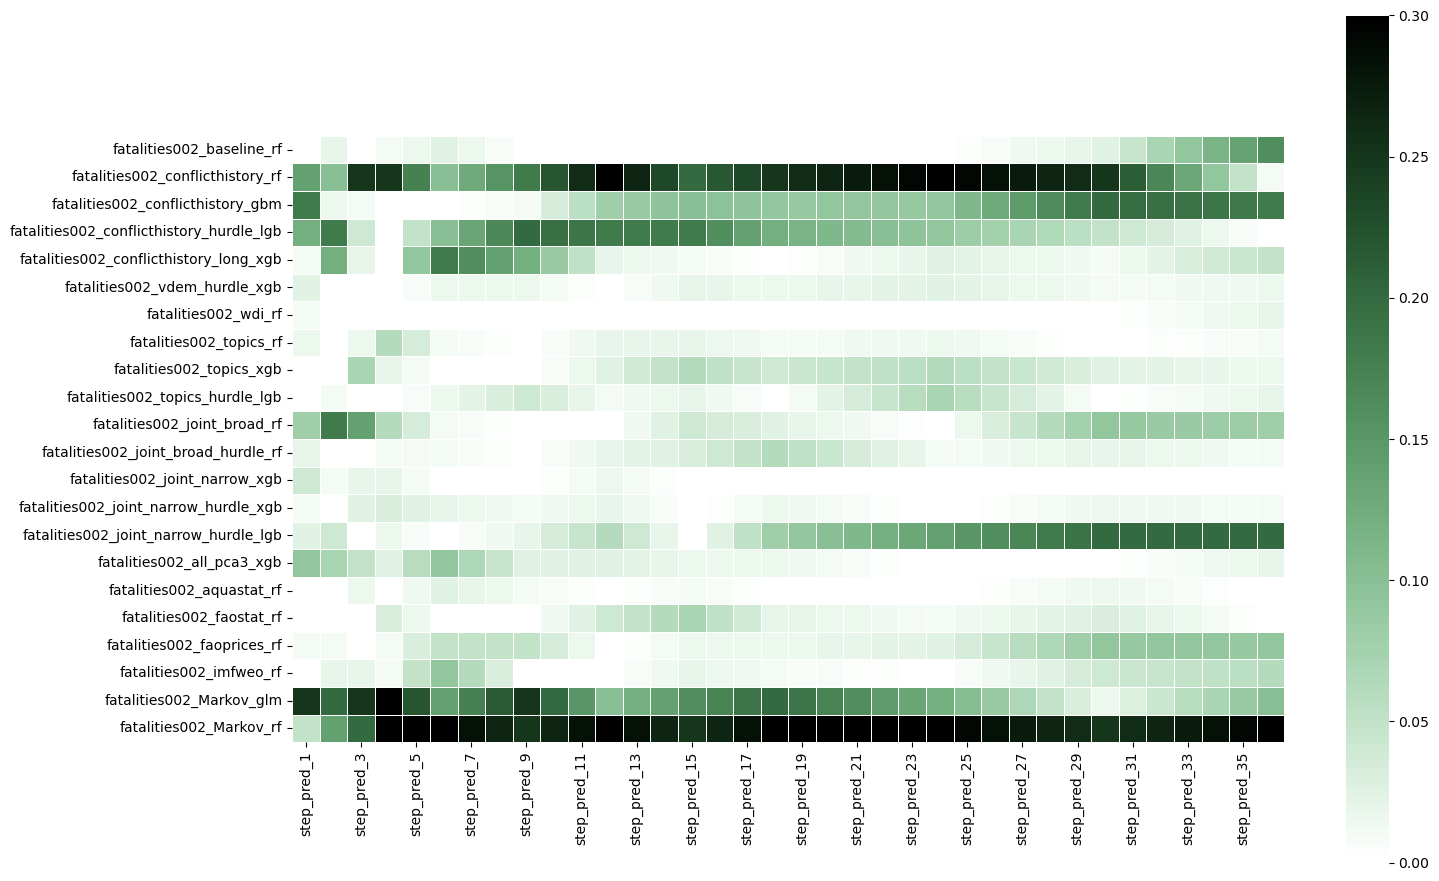

In [10]:
import seaborn as sns
palette = 'vlag'
palette = sns.color_palette('BrBG',n_colors=50)
palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=1, n_colors=100)

fig, ax =plt.subplots(1,figsize=(16,11))
ax = sns.heatmap(i_weights_df, xticklabels=2, linewidths=.5, cmap=palette,square=True)
filename = overleafpath + 'genetic_weights.png'
plt.savefig(filename, dpi=300)

In [11]:
# Constructing dfs to hold the predictions
# A list of dictionaries organizing predictions and information as one step per entry,
# including a dataframe for each step with one column per prediction model
StepEnsembles = []

stepcols = ['ln_ged_sb_dep']
for step in steps:
    stepcols.append('step_pred_' + str(step))
for col in stepcols[1:]:  # Use the baseline as template to construct object
    Step_prediction = {
        'step_pred': col,
        'df_calib': pd.DataFrame(ModelList[0]['calib_df_calibrated']['ln_ged_sb_dep']), 
        'df_test': pd.DataFrame(ModelList[0]['test_df_calibrated']['ln_ged_sb_dep']),
        'ensembles_calib': pd.DataFrame(ModelList[0]['calib_df_calibrated']['ln_ged_sb_dep']),
        'ensembles_test': pd.DataFrame(ModelList[0]['test_df_calibrated']['ln_ged_sb_dep'])
    }
    for model in ModelList:
        modelname = model['modelname']
        Step_prediction['df_calib'][modelname] = model['calib_df_calibrated'][col]
        Step_prediction['df_test'][modelname] = model['test_df_calibrated'][col]
    StepEnsembles.append(Step_prediction)

# Calculating unweighted average ensembles
i = 0
for col in stepcols[1:]:
    # Unweighted average
    StepEnsembles[i]['ensembles_test']['unweighted_average'] = StepEnsembles[i]['df_test'].drop('ln_ged_sb_dep', axis=1).mean(axis=1)
    StepEnsembles[i]['ensembles_calib']['unweighted_average'] = StepEnsembles[i]['df_calib'].drop('ln_ged_sb_dep', axis=1).mean(axis=1)
#    StepEnsembles[i]['ensembles_calib'].loc['unweighted_average'] = StepEnsembles[i]['df_calib'].drop('ln_ged_sb_dep', axis=1).mean(axis=1)
    i = i + 1


In [12]:
ModelList[0]['calib_df_calibrated']

ln_ged_sb_dep  step_pred_1  step_pred_2  step_pred_3  \
month_id country_id                                                         
409      1                0.000000     0.005526     0.014117     0.020608   
         2                0.000000     0.003604     0.001934     0.002471   
         3                0.000000     0.003604     0.002016    -0.002633   
         4                0.000000     0.006270     0.016146     0.023164   
         5                0.000000     0.003604     0.001934     0.002471   
...                            ...          ...          ...          ...   
456      242              0.000000     0.018113     0.015218    -0.000054   
         243              0.000000     0.005020     0.009487    -0.001790   
         244              0.000000     0.027120     0.032132     0.027463   
         245              1.609438     2.413492     1.864532     1.688268   
         246              4.143135     4.216695     2.903240     3.158177   

                     step_pred_4  step_pred_5  step_pred_6  step_pred_7  \
month_id country_id                                                       
409      1              0.029257     0.031089     0.026614     0.005068   
         2              0.002526     0.004597     0.007427     0.049954   
         3              0.001533     0.000194     0.001369    -0.001891   
         4              0.031626     0.032432     0.030826     0.000594   
         5              0.002526     0.004597     0.007427     0.049954   
...                          ...          ...          ...          ...   
456      242            0.004160     0.003546     0.004580    -0.021564   
         243            0.002713     0.001794     0.003112    -0.022130   
         244            0.030850     0.032438     0.030791    -0.010523   
         245            1.276427     1.335049     2.008927     4.682785   
         246            2.960671     3.853446     3.027677     2.473072   

                     step_pred_8  step_pred_9  ...  step_pred_27  \
month_id country_id                            ...                 
409      1              0.028537     0.034781  ...      0.095312   
         2              0.050268     0.063405  ...      0.044474   
         3              0.007777     0.003486  ...      0.038115   
         4              0.007403     0.008923  ...      0.103234   
         5              0.050268     0.063405  ...      0.044474   
...                          ...          ...  ...           ...   
456      242            0.002113    -0.001726  ...      0.049655   
         243            0.002031    -0.001804  ...      0.043667   
         244            0.007842     0.006176  ...      0.055846   
         245            2.199119     1.791250  ...      2.402612   
         246            5.377000     2.557591  ...      1.804223   

                     step_pred_28  step_pred_29  step_pred_30  step_pred_31  \
month_id country_id                                                           
409      1               0.109192      0.118971      0.098707      0.136028   
         2               0.039671      0.037705      0.053261      0.047303   
         3               0.036575      0.035081      0.038948      0.039306   
         4               0.120296      0.128923      0.124912      0.148415   
         5               0.039671      0.037705      0.053261      0.047303   
...                           ...           ...           ...           ...   
456      242             0.058062      0.052074      0.045767      0.057456   
         243             0.050921      0.047523      0.044107      0.058214   
         244             0.059243      0.092724      0.127352      0.150684   
         245             2.196429      2.765757      5.132737      5.136608   
         246             1.352259      2.454723      1.569915      2.946707   

                     step_pred_32  step_pred_33  step_pred_34  step_pred_35  \
month_id country_id                                

In [13]:
StepEnsembles[0]['ensembles_calib']['unweighted_average']

month_id  country_id
409       1             0.004144
          2             0.003315
          3             0.001519
          4             0.013191
          5             0.005196
                          ...   
456       242           0.014190
          243           0.005715
          244           0.032586
          245           2.421178
          246           3.597146
Name: unweighted_average, Length: 9168, dtype: float64

In [17]:
i_weights_df.index.values

array(['fatalities002_baseline_rf', 'fatalities002_conflicthistory_rf',
       'fatalities002_conflicthistory_gbm',
       'fatalities002_conflicthistory_hurdle_lgb',
       'fatalities002_conflicthistory_long_xgb',
       'fatalities002_vdem_hurdle_xgb', 'fatalities002_wdi_rf',
       'fatalities002_topics_rf', 'fatalities002_topics_xgb',
       'fatalities002_topics_hurdle_lgb', 'fatalities002_joint_broad_rf',
       'fatalities002_joint_broad_hurdle_rf',
       'fatalities002_joint_narrow_xgb',
       'fatalities002_joint_narrow_hurdle_xgb',
       'fatalities002_joint_narrow_hurdle_lgb',
       'fatalities002_all_pca3_xgb', 'fatalities002_aquastat_rf',
       'fatalities002_faostat_rf', 'fatalities002_faoprices_rf',
       'fatalities002_imfweo_rf', 'fatalities002_Markov_glm',
       'fatalities002_Markov_rf'], dtype=object)

In [18]:

# Calculating weighted average ensembles
# Based on the weights_df dataframe filled with Mihai's weights above

def ensemble_predictions(yhats, weights):
    # make predictions
    yhats = np.array(yhats)
    # weighted sum across ensemble members
    result = np.dot(weights,yhats)
    return result

# normalize a vector to have unit norm
def normalize(weights):
    # calculate l1 vector norm
    result = norm(weights, 1)
    # check for a vector of all zeros
    if result == 0.0:
        return weights
    # return normalized vector (unit norm)
    return weights / result

mult_dict={i_weights_df.index.values[i]:i_weights_df['step_pred_1'][i] for i in range(len(i_weights_df['step_pred_1']))}

i = 0
for col in stepcols[1:]:
    # Unweighted average
    df_calib = StepEnsembles[i]['df_calib'].drop('ln_ged_sb_dep', axis=1)
    df_test = StepEnsembles[i]['df_test'].drop('ln_ged_sb_dep', axis=1)
    StepEnsembles[i]['ensembles_calib']['weighted_average'] = (df_calib.mul(mult_dict,axis='columns')).sum(axis=1)
    StepEnsembles[i]['ensembles_test']['weighted_average'] =  (df_test.mul(mult_dict,axis='columns')).sum(axis=1)
    print('calib_sum',(df_calib.mul(mult_dict,axis='columns')).sum(axis=1))
    i = i + 1

calib_sum month_id  country_id
409       1             0.004315
          2             0.002597
          3             0.000849
          4             0.019535
          5             0.003665
                          ...   
456       242           0.011156
          243           0.006794
          244           0.032699
          245           2.571762
          246           3.997623
Length: 9168, dtype: float64
calib_sum month_id  country_id
409       1             0.008869
          2             0.004414
          3             0.000161
          4             0.005717
          5             0.006401
                          ...   
456       242           0.026318
          243           0.007377
          244           0.043560
          245           2.162367
          246           3.654655
Length: 9168, dtype: float64
calib_sum month_id  country_id
409       1             0.006732
          2             0.002769
          3             0.000708
          4             

Length: 9168, dtype: float64
calib_sum month_id  country_id
409       1             0.045811
          2             0.026612
          3             0.025863
          4             0.035938
          5             0.027845
                          ...   
456       242           0.091914
          243           0.057119
          244           0.289839
          245           4.212031
          246           2.401209
Length: 9168, dtype: float64
calib_sum month_id  country_id
409       1             0.065871
          2             0.055873
          3             0.028241
          4             0.108776
          5             0.037468
                          ...   
456       242           0.095626
          243           0.062642
          244           0.294779
          245           4.175106
          246           2.445987
Length: 9168, dtype: float64
calib_sum month_id  country_id
409       1             0.056716
          2             0.027720
          3             0.02

In [19]:
StepEnsembles[0]['df_calib']

ln_ged_sb_dep  fatalities002_baseline_rf  \
month_id country_id                                             
409      1                0.000000                   0.005526   
         2                0.000000                   0.003604   
         3                0.000000                   0.003604   
         4                0.000000                   0.006270   
         5                0.000000                   0.003604   
...                            ...                        ...   
456      242              0.000000                   0.018113   
         243              0.000000                   0.005020   
         244              0.000000                   0.027120   
         245              1.609438                   2.413492   
         246              4.143135                   4.216695   

                     fatalities002_conflicthistory_rf  \
month_id country_id                                     
409      1                                   0.003378   
         2                                   0.003378   
         3                                   0.003378   
         4                                   0.003378   
         5                                   0.003378   
...                                               ...   
456      242                                 0.004230   
         243                                 0.003378   
         244                                 0.003524   
         245                                 2.521707   
         246                                 3.569197   

                     fatalities002_conflicthistory_gbm  \
month_id country_id                                      
409      1                                   -0.000017   
         2                                   -0.000017   
         3                                   -0.000017   
         4                                    0.065192   
         5                                    0.007366   
...                                                ...   
456      242                                 -0.001212   
         243                                  0.002347   
         244                                 -0.000017   
         245                                  2.312664   
         246                                  4.064263   

                     fatalities002_conflicthistory_hurdle_lgb  \
month_id country_id                                             
409      1                                          -0.000060   
         2                                          -0.001076   
         3                                          -0.001138   
         4                                           0.000382   
         5                                          -0.001445   
...                                                       ...   
456      242                                         0.010468   
         243                                         0.009918   
         244                                         0.006851   
         245                                         2.111231   
         246                                         4.184919   

                     fatalities002_conflicthistory_long_xgb  \
month_id country_id                                           
409      1                                         0.003192   
         2                                         0.003192   
         3                                         0.003192   
         4                                         0.031983   
         5                                         0.003192   
...                                                     ...   
456      242                                       0.006230   
         243                                       0.003192   
         244                                       0.004523   
         245                                       2.409996   
         246                                       2.866890   

            

In [20]:
i_weights_df.columns

Index(['step_pred_1', 'step_pred_2', 'step_pred_3', 'step_pred_4',
       'step_pred_5', 'step_pred_6', 'step_pred_7', 'step_pred_8',
       'step_pred_9', 'step_pred_10', 'step_pred_11', 'step_pred_12',
       'step_pred_13', 'step_pred_14', 'step_pred_15', 'step_pred_16',
       'step_pred_17', 'step_pred_18', 'step_pred_19', 'step_pred_20',
       'step_pred_21', 'step_pred_22', 'step_pred_23', 'step_pred_24',
       'step_pred_25', 'step_pred_26', 'step_pred_27', 'step_pred_28',
       'step_pred_29', 'step_pred_30', 'step_pred_31', 'step_pred_32',
       'step_pred_33', 'step_pred_34', 'step_pred_35', 'step_pred_36'],
      dtype='object')

In [21]:
# Reshape the ensemble predictions
EnsembleList = []
genetic = {
        'modelname': 'ensemble_genetic',
        'algorithm': '',
        'depvar': "ln_ged_sb_dep",
        'calib_df_calibrated': ModelList[0]['calib_df_calibrated'].copy(),
        'test_df_calibrated': ModelList[0]['test_df_calibrated'].copy(),
    }    

for step in StepEnsembles:
    colname = step['step_pred']
    print(colname)
    genetic['calib_df_calibrated'][colname] = step['ensembles_calib']['weighted_average']
    genetic['test_df_calibrated'][colname] = step['ensembles_test']['weighted_average']

EnsembleList.append(genetic)


step_pred_1
step_pred_2
step_pred_3
step_pred_4
step_pred_5
step_pred_6
step_pred_7
step_pred_8
step_pred_9
step_pred_10
step_pred_11
step_pred_12
step_pred_13
step_pred_14
step_pred_15
step_pred_16
step_pred_17
step_pred_18
step_pred_19
step_pred_20
step_pred_21
step_pred_22
step_pred_23
step_pred_24
step_pred_25
step_pred_26
step_pred_27
step_pred_28
step_pred_29
step_pred_30
step_pred_31
step_pred_32
step_pred_33
step_pred_34
step_pred_35
step_pred_36


In [22]:
step['ensembles_test'].describe()

,ln_ged_sb_dep,unweighted_average,weighted_average
count,9168.000000,9168.000000,9168.000000
mean,0.514870,0.649088,0.715339
std,1.379484,1.242864,1.364676
min,0.000000,0.052975,0.048848
25%,0.000000,0.069023,0.066457
50%,0.000000,0.096956,0.102506
75%,0.000000,0.332481,0.406631
max,9.327857,7.829742,8.990380


In [23]:
df_calib

fatalities002_baseline_rf  \
month_id country_id                              
409      1                            0.102624   
         2                            0.099294   
         3                            0.056928   
         4                            0.093289   
         5                            0.099294   
...                                        ...   
456      242                          0.071198   
         243                          0.088289   
         244                          0.080813   
         245                          4.502360   
         246                          1.821846   

                     fatalities002_conflicthistory_rf  \
month_id country_id                                     
409      1                                   0.133243   
         2                                   0.062402   
         3                                   0.058621   
         4                                   0.134329   
         5                                   0.062402   
...                                               ...   
456      242                                 0.059947   
         243                                 0.055297   
         244                                 0.058458   
         245                                 3.114932   
         246                                 3.188452   

                     fatalities002_conflicthistory_gbm  \
month_id country_id                                      
409      1                                    0.094389   
         2                                    0.049667   
         3                                    0.049667   
         4                                    0.154512   
         5                                    0.060577   
...                                                ...   
456      242                                  0.016715   
         243                                  0.048581   
         244                                  0.074070   
         245                                  4.309321   
         246                                  2.595987   

                     fatalities002_conflicthistory_hurdle_lgb  \
month_id country_id                                             
409      1                                           0.064716   
         2                                           0.064508   
         3                                           0.063917   
         4                                           0.067868   
         5                                           0.063796   
...                                                       ...   
456      242                                         0.129225   
         243                                         0.067034   
         244                                         0.079286   
         245                                         3.649097   
         246                                         3.683700   

                     fatalities002_conflicthistory_long_xgb  \
month_id country_id                                           
409      1                                         0.121869   
         2                                         0.046273   
         3                                         0.046273   
         4                                         0.206653   
         5                                         0.045648   
...                                                     ...   
456      242                                       0.297631   
         243                                       0.069183   
         244                                       0.222136   
         245                                       4.127937   
         246                                       4.498220   

                     fatalities002_vdem_hurdle_xgb  fatalities002_wdi_rf  \
month_id country_id                                                        
409      1                                0.053334     

In [24]:
StepEnsembles[35]['ensembles_calib']['unweighted_average'].describe()

count    9168.000000
mean        0.516813
std         1.070994
min         0.035606
25%         0.064365
50%         0.078759
75%         0.259661
max         6.811965
Name: unweighted_average, dtype: float64

In [25]:
# Save ensemble predictions
predstore_calib = level +  '_' + genetic['modelname'] + '_calib'
genetic['calib_df_calibrated'].forecasts.set_run(run_id)
genetic['calib_df_calibrated'].forecasts.to_store(name=predstore_calib, overwrite = True)
predstore_test = level +  '_' + genetic['modelname'] + '_test'
genetic['test_df_calibrated'].forecasts.set_run(run_id)
genetic['test_df_calibrated'].forecasts.to_store(name=predstore_test, overwrite = True)

In [26]:
genetic['test_df_calibrated'].describe()

,ln_ged_sb_dep,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,...,step_pred_27,step_pred_28,step_pred_29,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36
count,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,...,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000
mean,0.514870,0.577057,0.579811,0.597378,0.608419,0.602448,0.627757,0.631586,0.635492,0.636852,...,0.690561,0.686111,0.696700,0.707498,0.715229,0.714316,0.723487,0.708956,0.720535,0.715339
std,1.379484,1.396792,1.381446,1.396700,1.406992,1.368832,1.431473,1.418914,1.368800,1.392289,...,1.351085,1.337728,1.361020,1.373466,1.399926,1.392705,1.399910,1.365506,1.387881,1.364676
min,0.000000,-0.000694,-0.004580,-0.002999,-0.024536,-0.034279,-0.038292,0.003394,0.007431,0.015640,...,0.033165,0.031316,0.032843,0.037791,0.039153,0.042098,0.048114,0.043735,0.049577,0.048848
25%,0.000000,0.004538,0.005731,0.008338,0.005496,0.007532,0.009161,0.018324,0.024804,0.027979,...,0.045039,0.044424,0.045479,0.050380,0.053454,0.055163,0.060578,0.062442,0.062725,0.066457
50%,0.000000,0.018435,0.010604,0.020024,0.011089,0.022905,0.017876,0.028335,0.052999,0.045399,...,0.080148,0.080249,0.083979,0.084437,0.087600,0.094475,0.097618,0.096026,0.097476,0.102506
75%,0.000000,0.123981,0.143401,0.194476,0.181389,0.210000,0.252763,0.264143,0.275753,0.277147,...,0.388515,0.375625,0.376712,0.410572,0.383032,0.392310,0.406602,0.388902,0.400433,0.406631
max,9.327857,9.489864,8.330074,9.220032,8.082892,8.165416,8.598522,8.399473,8.805993,8.347243,...,8.242546,7.647020,8.222768,8.330642,8.328339,8.395057,8.681575,8.587485,8.799641,8.990380


In [ ]:
# See which genetic ensembles are in prediction storage
ViewsMetadata().with_name('genetic').fetch()